# Double Pendulum with Python package PyDy

In [12]:
from __future__ import print_function, division
from sympy import symbols, simplify
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)
from sympy.physics.mechanics import inertia, RigidBody
from sympy import trigsimp
from sympy.physics.mechanics import KanesMethod
from numpy import deg2rad, rad2deg, array, zeros, linspace
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ivisual import *
from IPython.display import display, clear_output

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Reference frames

In [1]:
inertial_frame = ReferenceFrame('I')

pendulum_frames = [ReferenceFrame('P0'),
                   ReferenceFrame('P1')]


(MainThread) backend module://ipykernel.pylab.backend_inline version unknown


ERROR! Session/line number was not unique in database. History logging moved to new session 556


In [2]:
psis = [dynamicsymbols('psi0'), #Pendulum1 angle
        dynamicsymbols('psi1')] #Pendulum2 angle


In [3]:
pendulum_frames[0].orient(inertial_frame, 'Axis', (psis[0], inertial_frame.z))
pendulum_frames[1].orient(pendulum_frames[0], 'Axis', (psis[1], pendulum_frames[0].z))


In [4]:
pendulum_frames[0].dcm(inertial_frame)

Matrix([
[ cos(psi0), sin(psi0), 0],
[-sin(psi0), cos(psi0), 0],
[         0,         0, 1]])

In [5]:
simplify(pendulum_frames[1].dcm(inertial_frame))

Matrix([
[ cos(psi0 + psi1), sin(psi0 + psi1), 0],
[-sin(psi0 + psi1), cos(psi0 + psi1), 0],
[                0,                0, 1]])

## Define some points

In [6]:
attachment = Point('A')

Lcgs = [symbols('Lcg0'),
       symbols('Lcg1')]

#end_points = [symbols('end0'),
#              symbols('end1')]

pendulum_lengths = [symbols('L0'),
                    symbols('L1')]
    

pendulum_mass_centers = [Point('cg0'),
                        Point('cg1')]

pendulum_end_points = [Point('end0'),
                       Point('end1')]

pendulum_end_points[0].set_pos(attachment, pendulum_lengths[0]*pendulum_frames[0].y)
pendulum_end_points[1].set_pos(pendulum_end_points[0], pendulum_lengths[1]*pendulum_frames[1].y)

pendulum_mass_centers[0].set_pos(attachment, Lcgs[0]*pendulum_frames[0].y)
pendulum_mass_centers[1].set_pos(pendulum_end_points[0], Lcgs[1]*pendulum_frames[1].y)


## Kinematical Differential Equations

In [7]:
rs = [dynamicsymbols('r0'), # Pendulum0 rate
      dynamicsymbols('r1')] # Pendulum1 rate
pendulum_end_point_velocities = [dynamicsymbols('pev0'),
                                dynamicsymbols('pev1')]

In [8]:
kinematical_differential_equations = [rs[0] - psis[0].diff(),
                                      rs[1] - psis[1].diff()
                                     ]
kinematical_differential_equations

[r0 - psi0', r1 - psi1']

## Angular Velocities

In [9]:
pendulum_frames[0].set_ang_vel(inertial_frame,rs[0]*inertial_frame.z)
pendulum_frames[1].set_ang_vel(pendulum_frames[0],rs[1]*inertial_frame.z)


In [10]:
pendulum_frames[0].ang_vel_in(inertial_frame)

r0*I.z

In [11]:
pendulum_frames[1].ang_vel_in(inertial_frame)

(r0 + r1)*I.z

## Linear Velocities

In [13]:
attachment.set_vel(inertial_frame, 0)


In [14]:
pendulum_mass_centers[0].v2pt_theory(attachment, inertial_frame, pendulum_frames[0])
pendulum_mass_centers[0].vel(inertial_frame)

- Lcg0*r0*P0.x

In [15]:
pendulum_end_points[0].v2pt_theory(attachment, inertial_frame, pendulum_frames[0])
pendulum_end_points[0].vel(inertial_frame)

- L0*r0*P0.x

In [16]:
pendulum_mass_centers[1].v2pt_theory(pendulum_end_points[0], inertial_frame, pendulum_frames[1])
pendulum_mass_centers[1].vel(inertial_frame)

- L0*r0*P0.x - Lcg1*(r0 + r1)*P1.x

## Mass

In [17]:
pendulum_masses = [symbols('m_P0'),symbols('m_P1')]

## Inertia

In [18]:
Izzs = [symbols('I_zz0'),symbols('I_zz1')]

In [19]:
pendulum_dyadics = [inertia(pendulum_frames[0], 0, 0, Izzs[0]),
                   inertia(pendulum_frames[1], 0, 0, Izzs[1])]

In [20]:
pendulum_dyadics[0]

I_zz0*(P0.z|P0.z)

In [21]:
pendulum_dyadics[0].to_matrix(pendulum_frames[0])

Matrix([
[0, 0,     0],
[0, 0,     0],
[0, 0, I_zz0]])

In [22]:
pendulum_central_inertias = [(pendulum_dyadics[0], pendulum_mass_centers[0]),
                             (pendulum_dyadics[1], pendulum_mass_centers[1])]
                             

In [23]:
pendulums = [RigidBody('Pendulum0', pendulum_mass_centers[0], pendulum_frames[0],pendulum_masses[0], 
                       pendulum_central_inertias[0]),
             RigidBody('Pendulum1', pendulum_mass_centers[1], pendulum_frames[1],pendulum_masses[1], 
                       pendulum_central_inertias[1])]

## Equations of Motion

In [24]:
coordinates = psis
coordinates

[psi0, psi1]

In [25]:
speeds = rs
speeds

[r0, r1]

In [26]:
kane = KanesMethod(inertial_frame, coordinates, speeds, kinematical_differential_equations)

In [27]:
g = symbols('g')

In [28]:
pendulum_grav_force_vectors = [pendulum_masses[0] * g * inertial_frame.y,
                               pendulum_masses[1] * g * inertial_frame.y]
pendulum_grav_force_vectors

[g*m_P0*I.y, g*m_P1*I.y]

In [29]:
pendulum_grav_forces = [(pendulum_mass_centers[0], pendulum_grav_force_vectors[0]),
                        (pendulum_mass_centers[1], pendulum_grav_force_vectors[1])]

In [30]:
attachement_torques = [dynamicsymbols('T_a0'),
                       dynamicsymbols('T_a1')]

pendulum_torque_vectors = [attachement_torques[0] * inertial_frame.z,
                           attachement_torques[1] * inertial_frame.z]
                           
pendulum_torque_vectors

[T_a0*I.z, T_a1*I.z]

In [31]:
pendulum_torques = [(pendulum_frames[0], pendulum_torque_vectors[0]),
                    (pendulum_frames[1], pendulum_torque_vectors[1])]

In [32]:
#loads = [pendulum_grav_force,
#        pendulum_torque]
loads = pendulum_grav_forces

loads

[(cg0, g*m_P0*I.y), (cg1, g*m_P1*I.y)]

In [33]:
bodies = pendulums

In [34]:
fr, frstar = kane.kanes_equations(bodies = bodies,loads = loads)

In [35]:
trigsimp(fr + frstar)

Matrix([
[L0*Lcg1*m_P1*(r0 + r1)**2*sin(psi1) - L0*Lcg1*m_P1*r0**2*sin(psi1) - L0*g*m_P1*sin(psi0) - Lcg0*g*m_P0*sin(psi0) - Lcg1*g*m_P1*sin(psi0 + psi1) - (I_zz1 + Lcg1*m_P1*(L0*cos(psi1) + Lcg1))*r1' - (I_zz0 + I_zz1 + Lcg0**2*m_P0 + m_P1*(L0**2 + 2*L0*Lcg1*cos(psi1) + Lcg1**2))*r0'],
[                                                                                                                                          -L0*Lcg1*m_P1*r0**2*sin(psi1) - Lcg1*g*m_P1*sin(psi0 + psi1) - (I_zz1 + Lcg1**2*m_P1)*r1' - (I_zz1 + Lcg1*m_P1*(L0*cos(psi1) + Lcg1))*r0']])

In [36]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

Matrix([
[1, 0,                                                                           0,                                       0],
[0, 1,                                                                           0,                                       0],
[0, 0, I_zz0 + I_zz1 + Lcg0**2*m_P0 + m_P1*(L0**2 + 2*L0*Lcg1*cos(psi1) + Lcg1**2), I_zz1 + Lcg1*m_P1*(L0*cos(psi1) + Lcg1)],
[0, 0,                                     I_zz1 + Lcg1*m_P1*(L0*cos(psi1) + Lcg1),                    I_zz1 + Lcg1**2*m_P1]])

In [37]:
forcing_vector = trigsimp(kane.forcing_full)
forcing_vector

Matrix([
[                                                                                                                                        r0],
[                                                                                                                                        r1],
[2*L0*Lcg1*m_P1*r0*r1*sin(psi1) + L0*Lcg1*m_P1*r1**2*sin(psi1) - L0*g*m_P1*sin(psi0) - Lcg0*g*m_P0*sin(psi0) - Lcg1*g*m_P1*sin(psi0 + psi1)],
[                                                                                      -Lcg1*m_P1*(L0*r0**2*sin(psi1) + g*sin(psi0 + psi1))]])

## Simulation

In [38]:
constants = [Lcgs[0],
             pendulum_lengths[0],
             pendulum_masses[0],            
             Izzs[0],
             Lcgs[1],
             pendulum_masses[1],            
             Izzs[1],
             g]

In [39]:
constants

[Lcg0, L0, m_P0, I_zz0, Lcg1, m_P1, I_zz1, g]

In [40]:
coordinates = psis
coordinates

[psi0, psi1]

In [41]:
speeds = rs
speeds

[r0, r1]

In [42]:
#specified = [pendulum_torque]
specified = []


right_hand_side = generate_ode_function(forcing_vector, coordinates,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

In [43]:
help(generate_ode_function)

Help on function generate_ode_function in module pydy.codegen.ode_function_generators:

generate_ode_function(*args, **kwargs)
    Generates a numerical function which can evaluate the right hand
    side of the first order ordinary differential equations from a
    system described by one of the following three symbolic forms:
    
        [1] x' = F(x, t, r, p)
    
        [2] M(x, p) x' = F(x, t, r, p)
    
        [3] M(q, p) u' = F(q, u, t, r, p)
            q' = G(q, u, t, r, p)
    
    where
    
        x : states, i.e. [q, u]
        t : time
        r : specified (exogenous) inputs
        p : constants
        q : generalized coordinates
        u : generalized speeds
        M : mass matrix (full or minimum)
        F : right hand side (full or minimum)
        G : right hand side of the kinematical differential equations
    
    The generated function is of the form F(x, t, p) or F(x, t, r, p)
    depending on whether the system has specified inputs or not.
    
    Par

In [44]:
help(right_hand_side)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, r, p)
    
    Parameters
    x : ndarray, shape(4,)
        The state vector is ordered as such:
            - psi0(t)
            - psi1(t)
            - r0(t)
            - r1(t)
    t : float
        The current time.
    r : dictionary; ndarray, shape(0,); function
    
        There are three options for this argument. (1) is more flexible but
        (2) and (3) are much more efficient.
    
        (1) A dictionary that maps the specified functions of time to floats,
        ndarrays, or functions that produce ndarrays. The keys can be a single
        specified symbolic function of time or a tuple of symbols. The total
        number of symbols must be equal to 0. If the value is a
        function it must be of the form g(x, t), where x is t

## Set the Initial Conditions, Parameter Values, and Time Array

In [45]:
x0 = array([deg2rad(45),deg2rad(-45),0,0])
x0

array([ 0.78539816, -0.78539816,  0.        ,  0.        ])

In [46]:
Ls = [20,20]
numerical_constants =  np.array([Ls[0]/2,  # pendulum_length [m]
                                 Ls[0],
                         10,  # pendulum_mass [kg]
                        100,  # pendulum_inertia [kg*m^2]
                        Ls[1]/2,  # pendulum_length [m]
                        10,  # pendulum_mass [kg]
                        100,  # pendulum_inertia [kg*m^2]    
                        9.81])  # acceleration due to gravity [m/s^2]


In [47]:
# %load exercise_solutions/n07_simulation_sim-setup.py
#numerical_specified = zeros(3)
#numerical_specified = {}
numerical_specified = {}
#numerical_specified['L0'] = 10
#numerical_specified['L'] = 10



args = {'constants': numerical_constants,
        'specified': numerical_specified}

frames_per_sec = 100
final_time = 15.0

t = linspace(0.0, final_time, final_time * frames_per_sec)

/Users/martinalexandersson/Dev/ForceMan/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


In [48]:
right_hand_side(x0, 0.0, numerical_specified, numerical_constants)

array([ 0.        ,  0.        , -0.63410437,  1.44933983])

In [49]:
import inspect
inspect.getsourcelines(right_hand_side)

(['            def rhs(*args):\n',
  '                # args: x, t, p\n',
  '                # or\n',
  '                # args: x, t, r, p\n',
  '\n',
  '                args = self._parse_all_args(*args)\n',
  '\n',
  '                q = args[0][:self.num_coordinates]\n',
  '                u = args[0][self.num_coordinates:]\n',
  '\n',
  '                xdot = self._base_rhs(q, u, *args[2:])\n',
  '\n',
  '                return xdot\n'],
 467)

## Integrate the Equations of Motion

In [50]:
y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))

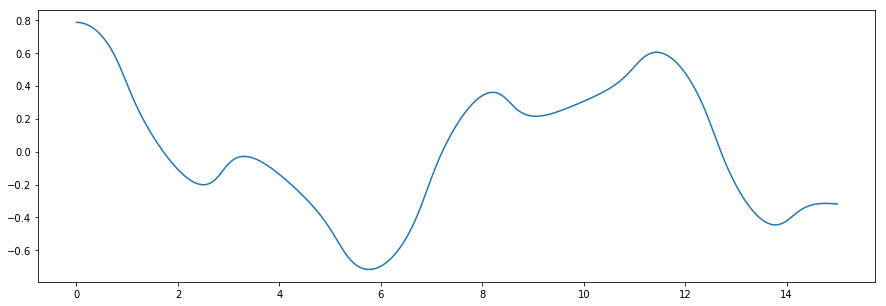

In [51]:
fig,ax = plt.subplots()
fig.set_size_inches(15,5)

ax.plot(t,y[:,0])


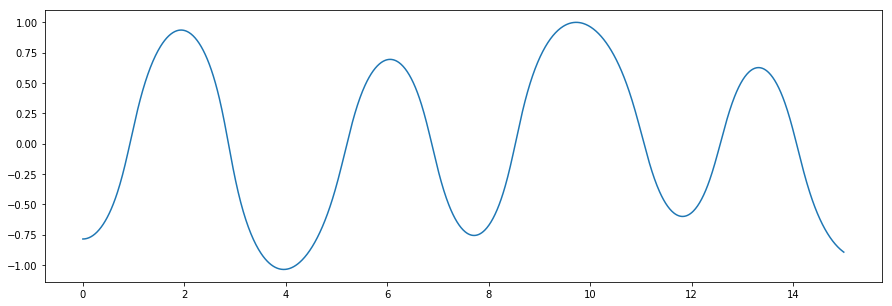

In [52]:
fig,ax = plt.subplots()
fig.set_size_inches(15,5)

ax.plot(t,y[:,1])

## Visualization

In [53]:
simplify(pendulum_end_points[0].pos_from(attachment).to_matrix(inertial_frame))

Matrix([
[-L0*sin(psi0)],
[ L0*cos(psi0)],
[            0]])

In [54]:
simplify(pendulum_end_points[1].pos_from(attachment).to_matrix(inertial_frame))

Matrix([
[-L0*sin(psi0) - L1*sin(psi0 + psi1)],
[ L0*cos(psi0) + L1*cos(psi0 + psi1)],
[                                  0]])

In [55]:
positions = [pendulum_end_points[0].pos_from(attachment),
             pendulum_end_points[1].pos_from(attachment)]

global_position_matrixes = []
for position in positions:
    global_position_matrixes.append(position.to_matrix(inertial_frame))

In [56]:

def play(x):
    
    index = int((len(t)-1)*x/100)
    
    
    
    #for global_position_matrix,pendulum_cylinder,psi_now,L,pendulum_length,psi in zip(
    #    global_position_matrixes,pendulum_cylinders,psi_nows,Ls,pendulum_lengths,psis):
    #    
    #    a = global_position_matrix.evalf(subs = {pendulum_length:L,psi:psi_now})
    #    pendulum_cylinder.axis = np.array(a.transpose().tolist()).astype(np.float64)[0]

    psi_nows = y[index,0:len(global_position_matrixes)] 
    
    a = global_position_matrixes[0].evalf(subs = {pendulum_lengths[0]:Ls[0],psis[0]:psi_nows[0]})
    end_point = np.array(a.transpose().tolist()).astype(np.float64)[0]
    pendulum_cylinders[0].axis = end_point
      
    a = global_position_matrixes[1].evalf(subs = {pendulum_lengths[0]:Ls[0],
                                                  pendulum_lengths[1]:Ls[1],
                                                  psis[0]:psi_nows[0],
                                                  psis[1]:psi_nows[1]})
    
    pendulum_cylinders[1].axis = np.array(a.transpose().tolist()).astype(np.float64)[0] - pendulum_cylinders[0].axis
    pendulum_cylinders[1].pos = pendulum_cylinders[0].axis

def play2(change):

    #x = interactive_plot.children[0].value
    x = slider.value

    play(x = x)

def plot(x):
    
    index = int((len(t)-1)*x/100)
    fig,ax = plt.subplots()
    ax.plot(t,y[:,0])
    ax.plot(t[index],y[index,0],'ro')
    display(fig)
    clear_output(wait=True)
    
    

In [ ]:

#from ipywidgets import interactive
#
#
#interactive_plot = interactive(plot, x=(0.0,100.0))
#display(interactive_plot)
#

In [ ]:
scene2 = canvas(width = 1000,height = 500,up=vector(0,-1,0))
vscale = 3
varr = arrow(pos=vector(0,0,0), axis=vscale*vector(1,0,0), color=color.red,shaftwidth=vscale*0.1)
varr = arrow(pos=vector(0,0,0), axis=vscale*vector(0,1,0), color=color.green,shaftwidth=vscale*0.1)
varr = arrow(pos=vector(0,0,0), axis=vscale*vector(0,0,1), color=color.blue,shaftwidth=vscale*0.1)

pendulum_radius = 0.1

pendulum_cylinders = []
colors = [color.orange,color.magenta]
for L,the_color in zip(Ls,colors):
    pendulum_cylinders.append(cylinder(pos = (0,0,0),axis = (0,1,0),length = L,radius = pendulum_radius,color = the_color))
    
play_widget = widgets.Play(
    #interval=0.05,
    step = 1,
    value=0,
    min=0,
    max=100,
    description="Press play",
    disabled=False

)
slider = widgets.FloatSlider()
widgets.jslink((play_widget, 'value'), (slider, 'value'))
#widgets.jslink((play_widget, 'value'), (interactive_plot.children[0], 'value'))


play_widget.observe(play2, names='value')

scene2.visible = True
display(scene2)
#display(interactive_plot.children[1])

widgets.HBox([play_widget, slider])
#widgets.HBox([play_widget, interactive_plot.children[0]])


<IPython.core.display.Javascript object>

In [ ]:
y